<a href="https://colab.research.google.com/github/hursoo/big_k-modern_1/blob/main/gb_041_topic_extract(big1_251)_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.개요
- DMR 적용해서 "개벽" 논조변화 분석
- 입력 데이터: gb_031에서 생성한 '기본 데이터프레임' <- 소스: 'gb_data_2.1.xlsx'

In [ ]:
# 구글 드라이브 마운트

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 경로 지정

file_path = '/content/drive/MyDrive/_big1_25-1_code/'

In [ ]:
## 런타임 다시 시작 후엔 이 셀 건너뛸 것 !

# =================================================================
# 1단계: 나눔 폰트 설치 (이 셀을 실행한 후, 런타임을 다시 시작해야 합니다)
# =================================================================
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
!pip install tomotopy

In [ ]:
import sys
import os, re
import pandas as pd
import numpy as np
import random
import warnings

from tomotopy import DMRModel
from tomotopy import TermWeight
from tomotopy import utils
import tomotopy as tp

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumBarunGothic' # 나눔바른고딕으로 설정 (Colab 기본 포함) ###
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호가 정상 표시되도록 설정

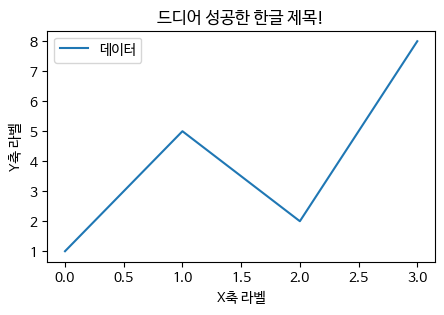

In [ ]:
# --- 이제 그래프를 그려도 경고가 뜨지 않습니다. ---

# 예시 그래프
# (여기에 원래 그리려던 그래프 코드를 넣으시면 됩니다)
plt.figure(figsize=(5, 3))
plt.title('드디어 성공한 한글 제목!')
plt.xlabel('X축 라벨')
plt.ylabel('Y축 라벨')
plt.plot([1, 5, 2, 8], label='데이터')
plt.legend()
plt.show()

In [ ]:
# gb_031에서 생성한 '기본 데이터프레임' 불러오기

gb_df = pd.read_excel(file_path + 'result/gb_data_2(doc,1g2g,wn_cls,20250414).xlsx')
gb_df

,doc_id,doc_raw,doc_split_12gram,r_no,title,w_new,ho_no,grid_1,wn_cls
0,1,創刊辭 强者도 부르짖고 弱者도 부르짖으며 優者도 부르짖고 劣者도 부르짖도다 東西南北...,창간 辭 강자 약자 優者 劣者 동서 남북 사해 팔방 소리 소리 판단 좌우 間 다수 ...,1,創刊辭,uk01,1,01q,0
1,2,哲人은 말하되 多數 人民의 聲은 곳 神의 聲이라 하엿나니 神은 스스로 要求가 없는지...,哲人 다수 인민 요구 인민 소리 요구 발표 갈앙 인민 소리 갈앙 다수 인민 갈앙 요...,1,創刊辭,uk01,1,01q,0
2,3,世界를 알라 사람은 天使도 안이며 野獸도 안이오 오즉 사람일 뿐이로다 이만치 進化된...,세계 사람 야수 사람 진화 진화 지식 진화 도덕 동물 세계 천당 지옥 세계 진화 국...,2,世界를 알라,uk01,1,01q,0
3,4,사람과 世界는 決코 논하볼 것이 안이엇다 사람으로 된 世界 世界로 된 사람 둘이 안...,사람 세계 사람 세계 세계 사람 세계 대표 시대 가치 사람 대표 문화 상징 符號 사...,2,世界를 알라,uk01,1,01q,0
4,5,過去는 論할 것이 업도다만은 今日과 가티 交通이 이마마하고 知識이 이마마하고 一切의...,過去 금일 교통 지식 일체 문물 오늘 세계 理解 공자 천하 천하 理解 오늘 날 사람...,2,世界를 알라,uk01,1,01q,0
...,...,...,...,...,...,...,...,...,...
6797,6798,미국에서는 每人에게 奴僕이 식 돌아감니다 단 機械奴僕만 이건 무슨 말이냐 하면 기계...,미국 노복 機械 노복 機械 力 운전 계산 人力 계산 미국 국민 사람 機械 輸入 숫자...,334,유로빠와 아메리카(一) 금년 봄에 모쓰크바 엑쓰페리멘탈 劇場에서 한 「트로츠끼」의 講演.,김철산,72,24q,2
6798,6799,매년 저축은ㅡ필요의 비용을 다 쓴 뒤의 것 말이지요ㅡ매년에 억 딸라 金 루불로는 억...,저축 필요 비용 미국 교과 書 실상 미국 富豪 캐나다 영국 미국 부분 미국 캐나다 ...,334,유로빠와 아메리카(一) 금년 봄에 모쓰크바 엑쓰페리멘탈 劇場에서 한 「트로츠끼」의 講演.,김철산,72,24q,2
6799,6800,그러고 또 캐나다는 아조 겸손스럽게 좀 유순하게 미국의 北邊繼續이라고ㅡ국제연맹의 축...,캐나다 미국 국제_연맹 국제_연맹 원인 경제 機械 캐나다 산업 북미 자본 점령 부분...,334,유로빠와 아메리카(一) 금년 봄에 모쓰크바 엑쓰페리멘탈 劇場에서 한 「트로츠끼」의 講演.,김철산,72,24q,2
6800,6801,25년 전에는 영국이 美보다 배나 더 되게 輸入하엿섯음니다 캐나다 사람들은 지금 그...,영국 미국 輸入 캐나다 사람 영국 一部 미국 호주 캐나다 진화 호주 일본 침입 보호...,334,유로빠와 아메리카(一) 금년 봄에 모쓰크바 엑쓰페리멘탈 劇場에서 한 「트로츠끼」의 講演.,김철산,72,24q,2


# 2.토픽추출 1단계: 혼잡도 사용

##  2.1.Model perplexity 산출

Running LDA...
Model perplexity (Log-likelihood)
Tomotopy가 사용 가능한 모든 CPU 코어(8개)를 사용하여 학습을 시작합니다.
1 topics: -4.59600217458714
2 topics: -4.8849521622135965
3 topics: -5.057719516731906
4 topics: -5.139941014658583
5 topics: -5.246983618593783
6 topics: -5.339696721583822
7 topics: -5.425295329551269
8 topics: -5.444988576509976
9 topics: -5.460930467236243
10 topics: -5.534433180351068
11 topics: -5.5457992801794935
12 topics: -5.579480620486954
13 topics: -5.5808474521514615
14 topics: -5.595582773561804
15 topics: -5.6105723669232805
16 topics: -5.6133517969826014
17 topics: -5.6288248748202765
18 topics: -5.632747858272127
19 topics: -5.6825691032515
20 topics: -5.668115073223511
21 topics: -5.681084450402668


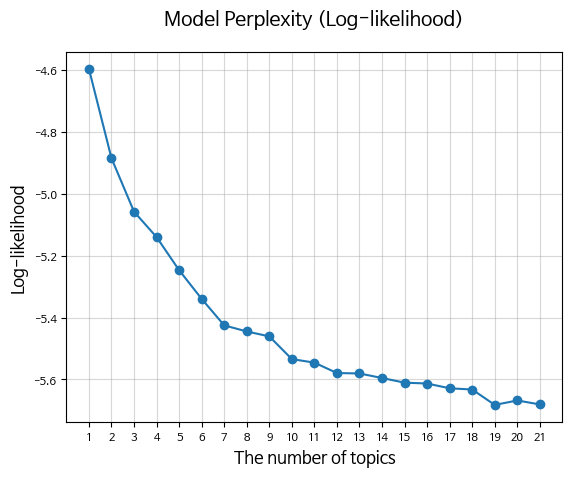

In [ ]:
import os
import random
import numpy as np
import tomotopy as tp
import matplotlib.pyplot as plt

# 멀티스레드 비활성화 (사용 CPU 제한 설정) -> 이 부분은 tomotopy의 workers 설정과 중복될 수 있으므로 주석 처리하거나 삭제하는 것이 좋습니다.
# os.environ["OMP_NUM_THREADS"] = "4"

# 경고 무시
warnings.filterwarnings("ignore", category=RuntimeWarning)


def train_lda(windowL, start_k=1, end_k=21, step=1, seed=100, burn_in=50, train_steps=500, workers=0): ### 1-20개까지
    """
    LDA 모델을 학습하고 토픽 수에 따른 로그 가능도를 계산합니다. (workers 파라미터 추가)

    Args:
        windowL (list): 학습 데이터 리스트
        ... (기존 파라미터들) ...
        workers (int): 학습에 사용할 CPU 코어 수. 0이면 가용한 모든 코어를 사용합니다.

    Returns:
        list, list: 토픽 수 리스트, 로그 가능도 리스트
    """
    # 파이썬, NumPy 모두 시드 고정
    random.seed(seed)
    np.random.seed(seed)

    # tomotopy가 사용할 CPU 코어 수 결정
    # workers=0은 "사용 가능한 모든 코어를 사용하라"는 의미입니다.
    # Colab에서 os.cpu_count()를 통해 확인된 코어 수만큼 자동으로 할당됩니다.
    if workers == 0:
        print(f"Tomotopy가 사용 가능한 모든 CPU 코어({os.cpu_count()}개)를 사용하여 학습을 시작합니다.")
    else:
        print(f"Tomotopy가 {workers}개의 CPU 코어를 사용하여 학습을 시작합니다.")

    ntopics, loglikelihood = [], []

    for k in range(start_k, end_k + 1, step):
        # Tomotopy LDAModel 생성 시 seed 파라미터 지정
        mdl = tp.LDAModel(k=k, seed=seed)
        # 데이터를 모델에 추가
        for doc in windowL:
            mdl.add_doc(doc)
        # 모델 학습
        mdl.burn_in = burn_in

        # *** 바로 이 부분에 workers 파라미터를 추가합니다! ***
        mdl.train(train_steps, workers=workers)

        # 결과 저장
        ntopics.append(k)
        loglikelihood.append(mdl.ll_per_word)
        print(f"{k} topics: {mdl.ll_per_word}")

    return ntopics, loglikelihood


def plot_loglikelihood(ntopics, loglikelihood, title="Model Perplexity (Log-likelihood)"):
    """
    로그 가능도에 따른 토픽 수 그래프를 그립니다.
    (이 함수는 변경할 필요가 없습니다.)
    """
    plt.plot(ntopics, loglikelihood, marker='o')
    plt.xlabel('The number of topics', fontsize=12)
    plt.ylabel('Log-likelihood', fontsize=12)
    plt.xticks(ntopics)
    plt.tick_params(axis='both', labelsize=8)
    plt.grid(True, alpha=0.5)
    plt.title(title, fontsize=14, pad=20)
    plt.show()


# === 실행 예시 ===
print("Running LDA...")
print("Model perplexity (Log-likelihood)")

# perplexity 실행하려면 아래 코드의 """를 삭제할 것
# 예: gb_df['doc_split_12gram'] 컬럼만 리스트화해서 모델 학습
windowL = gb_df['doc_split_12gram'].to_list()

# workers=0 (기본값) 으로 설정하여 모든 CPU 코어를 사용해 학습을 실행합니다.
# 별도로 workers 값을 지정하지 않으면 자동으로 모든 코어를 사용합니다.
ntopics, loglikelihood = train_lda(windowL, train_steps=500)

plot_loglikelihood(ntopics, loglikelihood)

# 만약 특정 개수의 코어만 사용하고 싶다면 (예: 4개)
# ntopics, loglikelihood = train_lda(windowL, train_steps=500, workers=4)


## 2.2.로그 가능도 그래프에서 변화율 분석

In [ ]:
!pip install kneed

자동으로 찾은 엘보 지점(k) : 4


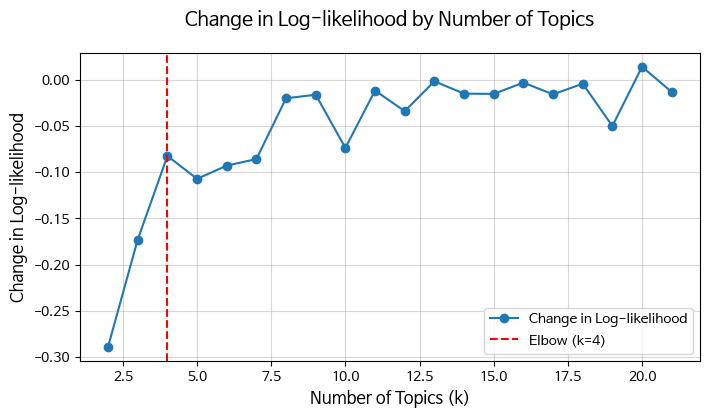

In [ ]:
from kneed import KneeLocator

# (예시) 토픽 수, 로그우도 등의 데이터를 준비
ntopics = list(range(1, 22))         # x축: 검토 대상 토픽 개수  ####
loglikelihood_1 = np.array(loglikelihood)    # loglikelihood <- ppl 값

# 변화율 계산 (1차 차분)
loglikelihood_diff = np.diff(loglikelihood_1)

# KneeLocator 적용
#  - x: ntopics[1:] (변화율에 해당하는 구간)
#  - y: loglikelihood_diff
#  - curve='concave' / 'convex' 중 데이터 형태에 맞춰 조정
#  - direction='increasing' / 'decreasing' 도 데이터 패턴(상승/하강)에 따라 조정
kl = KneeLocator(
    x=ntopics[1:],
    y=loglikelihood_diff,
    curve='concave',       # 보통 이렇게 지정하는 경우가 많음
    direction='increasing' # 변화율이 (-) -> (+)로 꺾이는 패턴이라면 'increasing'
)

elbow_point = kl.elbow
print("자동으로 찾은 엘보 지점(k) :", elbow_point)

# 그래프 시각화
plt.figure(figsize=(8, 4))
plt.plot(ntopics[1:], loglikelihood_diff, marker='o', label="Change in Log-likelihood")

if elbow_point is not None:
    plt.axvline(x=elbow_point, color='red', linestyle='--', label=f"Elbow (k={elbow_point})")

plt.xlabel('Number of Topics (k)', fontsize=12)
plt.ylabel('Change in Log-likelihood', fontsize=12)
plt.title('Change in Log-likelihood by Number of Topics', fontsize=14, pad=20)
plt.grid(alpha=0.5)
plt.legend(fontsize=10)
plt.show()

## 2.3.DMR 1차 모델

In [ ]:
print(gb_df.shape)
gb_df[:3]

(6802, 9)


,doc_id,doc_raw,doc_split_12gram,r_no,title,w_new,ho_no,grid_1,wn_cls
0,1,創刊辭 强者도 부르짖고 弱者도 부르짖으며 優者도 부르짖고 劣者도 부르짖도다 東西南北...,창간 辭 강자 약자 優者 劣者 동서 남북 사해 팔방 소리 소리 판단 좌우 間 다수 ...,1,創刊辭,uk01,1,01q,0
1,2,哲人은 말하되 多數 人民의 聲은 곳 神의 聲이라 하엿나니 神은 스스로 要求가 없는지...,哲人 다수 인민 요구 인민 소리 요구 발표 갈앙 인민 소리 갈앙 다수 인민 갈앙 요...,1,創刊辭,uk01,1,01q,0
2,3,世界를 알라 사람은 天使도 안이며 野獸도 안이오 오즉 사람일 뿐이로다 이만치 進化된...,세계 사람 야수 사람 진화 진화 지식 진화 도덕 동물 세계 천당 지옥 세계 진화 국...,2,世界를 알라,uk01,1,01q,0


In [ ]:
# 1) OpenMP 스레드 수 제한
os.environ["OMP_NUM_THREADS"] = "1"

# 2) 파이썬 자체 random, numpy 랜덤 시드 고정
def set_global_seeds(seed_value=1000):
    random.seed(seed_value)
    np.random.seed(seed_value)

# 3) `a_data`를 `metadata`로 변환하는 함수
def transform_a_data_to_metadata(misc: dict):
    return {'metadata': str(misc['a_data'])}

def run_dmr_model(gridL, lineL, num_topics=4, seed=1000, iterations=500, alpha=0.1, eta=0.01): ###
    """
    DMR 모델 실행 및 메타데이터 저장.

    Parameters:
        gridL (list): 메타데이터 리스트 (예: 발행 연도 등).
        lineL (list): 텍스트 데이터 리스트.
        num_topics (int): 토픽 개수. 기본값은 12.
        seed (int): 랜덤 시드. 기본값은 1000.
        iterations (int): 학습 반복 횟수. 기본값은 500.
        alpha (float): 알파값 (문서-토픽 분포 하이퍼파라미터).
        eta (float): 베타값 (토픽-단어 분포 하이퍼파라미터).

    Returns:
        model (DMRModel): 학습된 DMR 모델.
        topics (list): 각 토픽별 상위 단어 리스트.
    """
    # 파이썬 랜덤, numpy 랜덤 시드 고정
    set_global_seeds(seed)

    print(f"\nTraining DMR Model with {num_topics} topics, alpha={alpha}, eta={eta}...")

    # DMR 모델 초기화(tomotopy 내부 시드 설정)
    model = DMRModel(
        k=num_topics,
        seed=seed,
        tw=TermWeight.ONE,
        alpha=alpha,
        eta=eta
    )
    corpus = utils.Corpus()

    # 코퍼스에 문서 추가
    for grid, line in zip(gridL, lineL):
        tokens = line.strip().split()
        corpus.add_doc(tokens, a_data=grid)

    # 모델에 코퍼스 추가 (메타데이터 변환 포함)
    model.add_corpus(corpus, transform=transform_a_data_to_metadata)

    # 학습
    for i in range(0, iterations, 20):  # 20단위로 학습 반복
        model.train(20)
        print(f"Iteration: {i + 20}\tLog-likelihood: {model.ll_per_word:.4f}")

    # 토픽 결과 저장 및 출력
    topics = [model.get_topic_words(i, top_n=20) for i in range(model.k)]
    for idx, topic in enumerate(topics):
        print(f"Topic {idx}: {[word[0] for word in topic]}")

    return model, topics

In [ ]:
# 사용 예시
gridL = gb_df['grid_1'].to_list()  # 메타데이터
lineL = gb_df['doc_split_12gram'].to_list()  # 텍스트 데이터

#모델 실행
model, topics = run_dmr_model(
    gridL, lineL, num_topics=4, seed=1000, iterations=500, alpha=0.1, eta=0.01  # alpha=0.05, eta=0.1
)


Training DMR Model with 4 topics, alpha=0.1, eta=0.01...
Iteration: 20	Log-likelihood: -7.9266
Iteration: 40	Log-likelihood: -7.7428
Iteration: 60	Log-likelihood: -7.6884
Iteration: 80	Log-likelihood: -7.6671
Iteration: 100	Log-likelihood: -7.6552
Iteration: 120	Log-likelihood: -7.6419
Iteration: 140	Log-likelihood: -7.6391
Iteration: 160	Log-likelihood: -7.6329
Iteration: 180	Log-likelihood: -7.6289
Iteration: 200	Log-likelihood: -7.6250
Iteration: 220	Log-likelihood: -7.6239
Iteration: 240	Log-likelihood: -7.6253
Iteration: 260	Log-likelihood: -7.6225
Iteration: 280	Log-likelihood: -7.6220
Iteration: 300	Log-likelihood: -7.6200
Iteration: 320	Log-likelihood: -7.6201
Iteration: 340	Log-likelihood: -7.6220
Iteration: 360	Log-likelihood: -7.6182
Iteration: 380	Log-likelihood: -7.6229
Iteration: 400	Log-likelihood: -7.6209
Iteration: 420	Log-likelihood: -7.6201
Iteration: 440	Log-likelihood: -7.6203
Iteration: 460	Log-likelihood: -7.6203
Iteration: 480	Log-likelihood: -7.6207
Iteration:

# 3.토픽추출 2단계: 안정성 반영

## 3.1.모델의 안정성 평가1: Jaccard Similarity
- 자카드 유사도 : 상위 단어의 유사성
- Jaccard Similarity 기반 매칭
- 판단 기준
    - 일반적으로, 토픽 모델링에서 0.5 이상의 Jaccard Similarity는 상당히 일관성 있는 결과로 평가됩니다.
    - 0.6 이상: 매우 안정적이고 일관성이 높음.
    - 0.5~0.6: 비교적 안정적인 결과로, 해석 가능.
    - 0.4~0.5: 약간의 변동성이 있으며, 추가 검토가 필요.
    - 0.4 이하: 결과가 불안정하거나, 모델 설정 및 데이터 문제를 의심해야 함.

In [ ]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from joblib import Parallel, delayed

# tomotopy는 import 되어 있다고 가정
# import tomotopy as tp
# from tomotopy import utils, DMRModel, TermWeight

# ======================================================================
# 모델 학습 함수 (변경 없음)
# ======================================================================
def run_dmr_model_1(gridL, lineL, num_topics=4, seed=1000, iterations=500, alpha=0.1, eta=0.01, workers=0):
    model = DMRModel(k=num_topics, seed=seed, tw=TermWeight.ONE, alpha=alpha, eta=eta)
    corpus = utils.Corpus()
    for grid, line in zip(gridL, lineL):
        tokens = line.strip().split(' ')
        corpus.add_doc(tokens, a_data=grid)
    model.add_corpus(corpus)
    for _ in range(0, iterations, 20):
        model.train(20, workers=workers)
    topics = [model.get_topic_words(i, top_n=10) for i in range(model.k)]
    return topics

# ======================================================================
# [핵심 로직] '기준 모델'과 비교하여 유사도를 계산하는 함수
# ======================================================================
def _calculate_pair_similarity(topics1, topics2):
    """ 단일 쌍의 토픽 리스트 간의 평균 자카드 유사도를 계산하는 헬퍼 함수 (변경 없음) """
    def jaccard_similarity(list1, list2):
        set1, set2 = set(list1), set(list2)
        return len(set1 & set2) / len(set1 | set2) if len(set1 | set2) != 0 else 0
    sim_matrix = np.zeros((len(topics1), len(topics2)))
    for i, topic1 in enumerate(topics1):
        for j, topic2 in enumerate(topics2):
            sim_matrix[i, j] = jaccard_similarity([w[0] for w in topic1], [w[0] for w in topic2])
    row_ind, col_ind = linear_sum_assignment(-sim_matrix)
    return np.mean([sim_matrix[row, col] for row, col in zip(row_ind, col_ind)])

def calculate_jaccard_with_reference(reference_topics, test_topics_list, workers=0):
    """ 기준 토픽과 나머지 테스트 토픽들 간의 유사도를 병렬로 계산합니다. """
    if not test_topics_list:
        return 0.0
    scores = Parallel(n_jobs=workers)(delayed(_calculate_pair_similarity)(reference_topics, test_topics) for test_topics in test_topics_list)
    return np.mean(scores)


# ======================================================================
# [시각화 및 조율] 여러 기준 시드로 교차 확인하고 결과를 하나의 그래프에 그리는 최종 함수
# ======================================================================
def visualize_cross_checked_stability(gridL, lineL, topic_range, num_runs, reference_seeds, iterations=500, alpha=0.1, eta=0.01, workers=-1):
    """
    여러 개의 기준 시드(reference_seeds)를 사용하여 안정성 검사를 반복하고,
    그 결과를 하나의 그래프에 그려 비교하여 신뢰도를 높입니다.
    """
    if workers == -1:
        workers = os.cpu_count()
        print(f"모든 CPU 코어({workers}개)를 사용하여 병렬 처리를 시작합니다.")

    plt.figure(figsize=(6, 4))
    total_start_time = time.time()

    # --- 각 기준 시드(reference_seed)에 대해 분석을 반복 ---
    for ref_seed in reference_seeds:
        print(f"\n===== 기준 시드(Reference Seed) = {ref_seed}로 분석 시작 =====")

        results_per_seed = []
        for num_topics in topic_range:
            print(f"  [{num_topics}개 토픽] 테스트 중...")

            # 1. 기준(Reference) 모델을 생성합니다.
            reference_topics = run_dmr_model_1(gridL, lineL, num_topics=num_topics, seed=ref_seed,
                                               iterations=iterations, alpha=alpha, eta=eta, workers=workers)

            # 2. 나머지 테스트 모델들을 병렬로 학습합니다.
            test_seeds = [s for s in range(ref_seed + 1, ref_seed + num_runs)]
            test_topics_list = Parallel(n_jobs=workers)(delayed(run_dmr_model_1)(
                gridL, lineL, num_topics=num_topics, seed=s,
                iterations=iterations, alpha=alpha, eta=eta, workers=1
            ) for s in test_seeds)

            # 3. 기준 모델과 테스트 모델들 간의 유사도를 병렬로 계산합니다.
            avg_similarity = calculate_jaccard_with_reference(reference_topics, test_topics_list, workers=workers)
            results_per_seed.append((num_topics, avg_similarity))

        # --- 현재 기준 시드의 결과를 그래프에 추가 ---
        topic_counts, similarities = zip(*results_per_seed)
        plt.plot(topic_counts, similarities, marker='o', linestyle='--', label=f'Ref. Seed: {ref_seed}')

    print(f"\n총 실행 시간: {time.time() - total_start_time:.2f}초")

    # --- 최종 그래프 설정 및 표시 ---
    plt.title('Cross-Checked Jaccard Similarity by Number of Topics', fontsize=16)
    plt.xlabel('Number of Topics', fontsize=12)
    plt.ylabel('Average Jaccard Similarity', fontsize=12)
    plt.xticks(list(topic_range))
    plt.grid(alpha=0.6)
    plt.legend(title='Reference Seed')
    plt.show()

In [ ]:
# === 최적화 및 교차 확인 코드 사용 ===
gridL = gb_df['grid_1'].to_list()  # 메타데이터
lineL = gb_df['doc_split_12gram'].to_list()  # 텍스트 데이터

# 확인할 기준 시드들을 리스트로 전달합니다. (예: 1000, 2000, 3000)
# 이 리스트에 있는 시드 개수만큼 전체 분석이 반복됩니다.

# visualize_cross_checked_stability(
#     gridL, lineL,
#     topic_range=range(2, 8),      # 토픽 개수 범위
#     num_runs=10,                  # 각 기준 시드 당 비교할 테스트 실행 횟수
#     reference_seeds=[1000, 2000, 3000], # 교차 확인할 기준 시드 리스트
#     iterations=500,               # 학습 반복 횟수
#     alpha=0.05,                   # 알파값
#     eta=0.1,                      # 베타값
#     workers=-1                    # 사용할 CPU 코어 수 (-1: 모두 사용)
# )

## 3.2.모델의 안정성 평가2: JS divergence
- JS 다이버전스 : 토픽별 단어 분포의 안정성

In [ ]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import jensenshannon
from joblib import Parallel, delayed

# tomotopy는 import 되어 있다고 가정
# import tomotopy as tp
# from tomotopy import utils, DMRModel, TermWeight

# ======================================================================
# [수정 1] 모델 학습 함수: 이제 'model 객체' 대신 '토픽 분포 리스트'를 반환합니다.
# ======================================================================
def run_dmr_model_for_js(gridL, lineL, num_topics=4, seed=1000, iterations=500, alpha=0.1, eta=0.01, workers=0):
    """ 병렬 처리를 위해 학습된 모델의 '토픽 분포 리스트'를 직접 반환합니다. """
    model = DMRModel(k=num_topics, seed=seed, tw=TermWeight.ONE, alpha=alpha, eta=eta)
    corpus = utils.Corpus()
    for grid, line in zip(gridL, lineL):
        tokens = line.strip().split(' ')
        corpus.add_doc(tokens, a_data=grid)
    model.add_corpus(corpus)
    for _ in range(0, iterations, 20):
        model.train(20, workers=workers)

    # 모델 객체 대신, pickle로 직렬화 가능한 토픽 분포 리스트를 반환합니다.
    topic_dists = [model.get_topic_word_dist(i) for i in range(model.k)]
    return topic_dists

# ======================================================================
# [수정 2] 핵심 로직: 이제 'model 객체' 대신 '토픽 분포 리스트'를 직접 입력받습니다.
# ======================================================================
def _calculate_pair_js_divergence(topic_dists1, topic_dists2):
    """ 단일 쌍의 토픽 분포 리스트 간의 평균 JSD를 계산하는 헬퍼 함수 """
    num_topics = len(topic_dists1)

    js_matrix = np.zeros((num_topics, num_topics))
    for i in range(num_topics):
        for j in range(num_topics):
            # 입력받은 분포를 바로 사용하여 JSD를 계산합니다.
            js_matrix[i, j] = jensenshannon(topic_dists1[i], topic_dists2[j], base=2.0)

    row_ind, col_ind = linear_sum_assignment(js_matrix)
    return np.mean(js_matrix[row_ind, col_ind])

def calculate_js_divergence_with_reference(reference_dists, test_dists_list, workers=0):
    """ 기준 분포와 나머지 테스트 분포들 간의 JSD를 병렬로 계산합니다. """
    if not test_dists_list:
        return 0.0
    # _calculate_pair_js_divergence 함수에 모델이 아닌 분포 리스트를 전달합니다.
    scores = Parallel(n_jobs=workers)(delayed(_calculate_pair_js_divergence)(reference_dists, test_dists) for test_dists in test_dists_list)
    return np.mean(scores)


# ======================================================================
# 시각화 및 조율 함수 (내부 호출 함수 이름만 변경, 구조는 동일)
# ======================================================================
def visualize_cross_checked_js_stability(gridL, lineL, topic_range, num_runs, reference_seeds, iterations=500, alpha=0.1, eta=0.01, workers=-1):
    """ JSD를 사용하여 안정성 검사를 반복하고, 그 결과를 하나의 그래프에 그려 비교합니다. """
    if workers == -1:
        workers = os.cpu_count()
        print(f"모든 CPU 코어({workers}개)를 사용하여 병렬 처리를 시작합니다.")

    plt.figure(figsize=(6, 4))
    total_start_time = time.time()

    for ref_seed in reference_seeds:
        print(f"\n===== 기준 시드(Reference Seed) = {ref_seed}로 JSD 분석 시작 =====")

        results_per_seed = []
        for num_topics in topic_range:
            print(f"  [{num_topics}개 토픽] 테스트 중...")

            # 1. 기준(Reference) 모델의 '토픽 분포'를 생성합니다.
            reference_dists = run_dmr_model_for_js(gridL, lineL, num_topics=num_topics, seed=ref_seed,
                                                   iterations=iterations, alpha=alpha, eta=eta, workers=workers)

            # 2. 나머지 테스트 모델들의 '토픽 분포 리스트'를 병렬로 학습/추출합니다.
            test_seeds = [s for s in range(ref_seed + 1, ref_seed + num_runs)]
            test_dists_list = Parallel(n_jobs=workers)(delayed(run_dmr_model_for_js)(
                gridL, lineL, num_topics=num_topics, seed=s,
                iterations=iterations, alpha=alpha, eta=eta, workers=1
            ) for s in test_seeds)

            # 3. 기준 분포와 테스트 분포들 간의 JSD를 병렬로 계산합니다.
            avg_divergence = calculate_js_divergence_with_reference(reference_dists, test_dists_list, workers=workers)
            results_per_seed.append((num_topics, avg_divergence))

        topic_counts, divergences = zip(*results_per_seed)
        plt.plot(topic_counts, divergences, marker='s', linestyle=':', label=f'Ref. Seed: {ref_seed}')

    print(f"\n총 실행 시간: {time.time() - total_start_time:.2f}초")

    plt.title('Cross-Checked Jensen-Shannon Divergence by Number of Topics', fontsize=16)
    plt.xlabel('Number of Topics', fontsize=12)
    plt.ylabel('Average JS Divergence (Lower is Better)', fontsize=12)
    plt.xticks(list(topic_range))
    plt.grid(alpha=0.6)
    plt.legend(title='Reference Seed')
    plt.show()

In [ ]:
# === JSD 교차 확인 코드 사용 ===
gridL = gb_df['grid_1'].to_list()  # 메타데이터
lineL = gb_df['doc_split_12gram'].to_list()  # 텍스트 데이터

# 확인할 기준 시드들을 리스트로 전달합니다.
# visualize_cross_checked_js_stability(
#     gridL, lineL,
#     topic_range=range(2, 8),
#     num_runs=10,
#     reference_seeds=[1000, 2000, 3000], # 교차 확인할 기준 시드 리스트
#     iterations=500,
#     alpha=0.05,
#     eta=0.1,
#     workers=-1
# )

(1) 알파(alpha)
- 문서-토픽 분포의 하이퍼파라미터입니다. / 각 문서가 얼마나 다양한 토픽을 포함할지를 제어합니다.
- 알파가 낮을 때 (예: 0.05): = 문서에서 소수의 주요 토픽에 집중됩니다.
    - 특정 문서가 하나 또는 몇 개의 토픽과 관련이 깊은 결과를 생성.
    - 문서의 주제가 상대적으로 명확하게 드러납니다.
- 알파가 높을 때 (예: 0.1): = 문서가 다양한 토픽을 포함할 가능성이 커집니다.
    - 토픽이 여러 문서에 골고루 나타날 수 있습니다.
    - 문서 내에서 여러 토픽이 혼합된 형태로 나타날 가능성이 높습니다.  
    
(2) 베타(eta)
- 토픽-단어 분포의 하이퍼파라미터입니다. / 각 토픽이 얼마나 다양한 단어를 포함할지를 제어합니다.
- 베타가 낮을 때 (예: 0.01): = 각 토픽이 소수의 주요 단어로 구성됩니다.
    - 특정 단어들이 특정 토픽에서 강하게 나타나며, 토픽의 특징이 명확해집니다.
- 베타가 높을 때 (예: 0.1): = 각 토픽이 다양한 단어로 구성됩니다.
    - 특정 단어에 치우치지 않고, 더 다양한 단어를 포함하는 경향이 있습니다.
    - 토픽의 경계가 덜 명확할 수 있습니다.

# 4.최종 토픽 추출

## 4.1.DMR 2차 모델

In [ ]:
# 사용 예시
gridL = gb_df['grid_1'].to_list()  # 메타데이터
lineL = gb_df['doc_split_12gram'].to_list()  # 텍스트 데이터

# 아래 실행하려면 """ 제거

# 여러 모델 실행
for seed in range(1001, 1006):
    print(f"\n--- Running model with seed: {seed} ---")
    model, topics = run_dmr_model(
        gridL, lineL, num_topics=4, seed=seed, iterations=1000, alpha=0.05, eta=0.1  # alpha=0.05, eta=0.1  ### k=4개
    )



--- Running model with seed: 1001 ---

Training DMR Model with 4 topics, alpha=0.05, eta=0.1...
Iteration: 20	Log-likelihood: -7.7937
Iteration: 40	Log-likelihood: -7.6552
Iteration: 60	Log-likelihood: -7.6240
Iteration: 80	Log-likelihood: -7.6129
Iteration: 100	Log-likelihood: -7.5996
Iteration: 120	Log-likelihood: -7.5940
Iteration: 140	Log-likelihood: -7.5909
Iteration: 160	Log-likelihood: -7.5932
Iteration: 180	Log-likelihood: -7.5936
Iteration: 200	Log-likelihood: -7.5901
Iteration: 220	Log-likelihood: -7.5912
Iteration: 240	Log-likelihood: -7.5942
Iteration: 260	Log-likelihood: -7.5944
Iteration: 280	Log-likelihood: -7.5895
Iteration: 300	Log-likelihood: -7.5903
Iteration: 320	Log-likelihood: -7.5932
Iteration: 340	Log-likelihood: -7.5927
Iteration: 360	Log-likelihood: -7.5935
Iteration: 380	Log-likelihood: -7.5915
Iteration: 400	Log-likelihood: -7.5910
Iteration: 420	Log-likelihood: -7.5913
Iteration: 440	Log-likelihood: -7.5913
Iteration: 460	Log-likelihood: -7.5901
Iteration:

<검토>
- seed = 100 이 국제정세 토픽을 좀 더 명확히 드러내므로 선택

## 4.2최종 토픽 선택 및 라벨링

In [ ]:
# 모델 실행
model, topics = run_dmr_model(
    gridL, lineL, num_topics=4, seed=100, iterations=1000, alpha=0.05, eta=0.1  # alpha=0.05, eta=0.1   ## seed를 '100'로 지정
)


Training DMR Model with 4 topics, alpha=0.05, eta=0.1...
Iteration: 20	Log-likelihood: -7.7973
Iteration: 40	Log-likelihood: -7.6713
Iteration: 60	Log-likelihood: -7.6434
Iteration: 80	Log-likelihood: -7.6339
Iteration: 100	Log-likelihood: -7.6242
Iteration: 120	Log-likelihood: -7.6200
Iteration: 140	Log-likelihood: -7.6175
Iteration: 160	Log-likelihood: -7.6169
Iteration: 180	Log-likelihood: -7.6097
Iteration: 200	Log-likelihood: -7.6124
Iteration: 220	Log-likelihood: -7.6095
Iteration: 240	Log-likelihood: -7.6064
Iteration: 260	Log-likelihood: -7.6060
Iteration: 280	Log-likelihood: -7.6022
Iteration: 300	Log-likelihood: -7.5991
Iteration: 320	Log-likelihood: -7.6013
Iteration: 340	Log-likelihood: -7.5965
Iteration: 360	Log-likelihood: -7.5956
Iteration: 380	Log-likelihood: -7.5968
Iteration: 400	Log-likelihood: -7.5972
Iteration: 420	Log-likelihood: -7.5966
Iteration: 440	Log-likelihood: -7.5953
Iteration: 460	Log-likelihood: -7.5950
Iteration: 480	Log-likelihood: -7.5942
Iteration:

In [ ]:
# 모델 요약 출력
model.summary(topic_word_top_n=20)

<Basic Info>
| DMRModel (current version: 0.13.0)
| 6802 docs, 257159 words
| Total Vocabs: 5828, Used Vocabs: 5828
| Entropy of words: 7.43552
| Entropy of term-weighted words: 7.43552
| Removed Vocabs: <NA>
| Metadata of docs and its distribution
|  01q: 193
|  02q: 223
|  03q: 296
|  04q: 292
|  05q: 435
|  06q: 333
|  07q: 410
|  08q: 413
|  09q: 152
|  10q: 298
|  11q: 315
|  12q: 261
|  13q: 198
|  14q: 393
|  15q: 456
|  16q: 254
|  17q: 154
|  18q: 201
|  19q: 223
|  20q: 224
|  21q: 226
|  22q: 248
|  23q: 324
|  24q: 280
|
<Training Info>
| Iterations: 1000, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -7.58973
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 0 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 0 (the number of top words to be removed)
| k: 4 (the number of topics between 1 ~ 32767)
| alpha: [0.05] (an initial value of exponential of mean of normal distribution for `lambdas`, giv

In [ ]:
# 모델 저장
model.save(file_path + 'result/gb_n_dmr_model(k=4,seed=100,0.05,0.1).bin') ###

In [ ]:
# 전제 : model, topics 이미 도출되어 있음.


# 결과에 적합한 토픽 라벨 부착

topic_labels = {
    0: "국제관계",
    1: "농촌경제",
    2: "사회주의",
    3: "개조사상"
}

# 결과를 DataFrame으로 정리 (예: 토픽 인덱스, 라벨, 상위 단어)
topic_data = []
for idx, topic in enumerate(topics):
    label = topic_labels.get(idx, f"Topic_{idx}")  # 혹시 라벨 딕셔너리에 없으면 'Topic_인덱스'로 fallback
    # 토픽의 상위 단어를 추출 (단어만)
    top_words = [word[0] for word in topic]
    # 하나의 문자열로 합치거나, 리스트 그대로 저장 가능
    top_words_str = ", ".join(top_words)

    # row 구성
    row = {
        "Topic_Index": idx,
        "Topic_Label": label,
        "Top_Words": top_words_str
    }
    topic_data.append(row)

In [ ]:
df_topics = pd.DataFrame(topic_data, columns=["Topic_Index", "Topic_Label", "Top_Words"])
df_topics

# Excel로 저장 (원하면)
df_topics.to_excel(file_path + "result/dmr_topics(토픽명 부착).xlsx", index=False)

# The End of Note